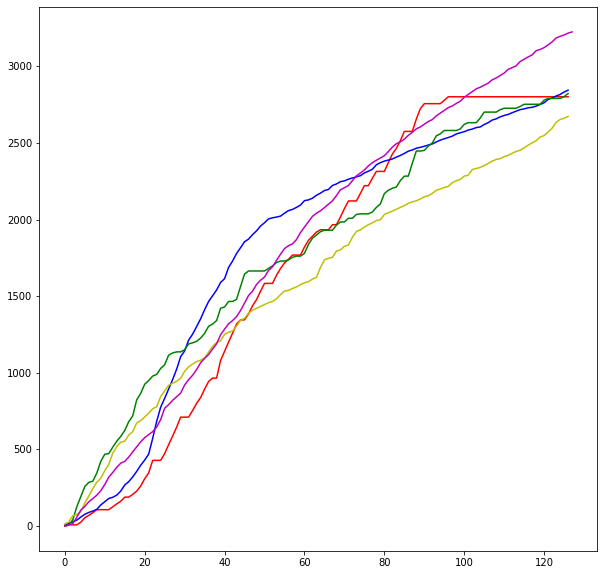

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
actual_tests = [4, 8, 8, 8, 25, 54, 70, 87, 107, 107, 107, 107, 126, 145, 162, 189, 189, 207, 228, 262, 309, 347, 429, 429, 429, 473, 532, 588, 646, 711, 711, 711, 755, 801, 839, 894, 944, 966, 966, 1081, 1141, 1201, 1259, 1319, 1346, 1346, 1385, 1438, 1478, 1533, 1584, 1584, 1584, 1637, 1681, 1717, 1741, 1769, 1769, 1769, 1821, 1865, 1892, 1919, 1934, 1934, 1934, 1967, 1967, 2017, 2072, 2122, 2122, 2122, 2171, 2222, 2222, 2270, 2315, 2315, 2315, 2373, 2428, 2465, 2515, 2576, 2576, 2576, 2656, 2724, 2757, 2757, 2757, 2757, 2757, 2779, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802, 2802]

model1 = [8, 17, 28, 39, 59, 77, 89, 98, 109, 138, 159, 180, 188, 202, 228, 268, 290, 321, 357, 397, 431, 470, 573, 684, 776, 834, 895, 957, 1024, 1106, 1143, 1214, 1253, 1302, 1353, 1412, 1466, 1503, 1541, 1590, 1615, 1688, 1730, 1779, 1817, 1856, 1873, 1902, 1927, 1958, 1980, 2005, 2012, 2017, 2023, 2042, 2059, 2067, 2080, 2095, 2124, 2129, 2140, 2159, 2173, 2190, 2197, 2223, 2233, 2248, 2253, 2264, 2272, 2279, 2287, 2305, 2316, 2329, 2358, 2372, 2382, 2389, 2396, 2408, 2419, 2432, 2447, 2455, 2466, 2472, 2479, 2487, 2494, 2507, 2519, 2528, 2536, 2545, 2559, 2567, 2574, 2585, 2591, 2601, 2605, 2621, 2633, 2650, 2658, 2671, 2680, 2687, 2698, 2708, 2718, 2723, 2730, 2733, 2741, 2752, 2763, 2785, 2794, 2807, 2817, 2833, 2845]

model2 = [0, 6, 41, 126, 192, 258, 285, 293, 345, 422, 469, 473, 515, 554, 585, 624, 681, 719, 824, 866, 926, 950, 979, 990, 1029, 1053, 1116, 1130, 1137, 1137, 1151, 1189, 1196, 1206, 1227, 1258, 1304, 1319, 1341, 1422, 1430, 1466, 1466, 1480, 1564, 1645, 1665, 1665, 1665, 1665, 1665, 1682, 1698, 1720, 1730, 1730, 1738, 1754, 1762, 1762, 1780, 1838, 1879, 1900, 1921, 1931, 1931, 1931, 1964, 1985, 1985, 2009, 2009, 2034, 2038, 2038, 2038, 2050, 2080, 2103, 2170, 2192, 2205, 2213, 2255, 2284, 2284, 2368, 2448, 2448, 2452, 2480, 2500, 2547, 2560, 2582, 2582, 2582, 2582, 2592, 2622, 2633, 2633, 2633, 2663, 2702, 2702, 2702, 2702, 2718, 2727, 2727, 2727, 2727, 2739, 2753, 2753, 2753, 2753, 2753, 2780, 2791, 2791, 2791, 2791, 2803, 2823]

model3 = [13, 27, 68, 75, 93, 151, 196, 245, 286, 312, 361, 403, 475, 518, 547, 554, 594, 616, 673, 688, 712, 737, 766, 779, 845, 882, 919, 932, 945, 965, 1010, 1039, 1058, 1073, 1083, 1098, 1135, 1173, 1198, 1210, 1251, 1266, 1273, 1305, 1344, 1356, 1390, 1409, 1421, 1434, 1446, 1458, 1466, 1483, 1511, 1534, 1538, 1551, 1561, 1576, 1588, 1595, 1612, 1624, 1688, 1738, 1748, 1754, 1795, 1803, 1826, 1834, 1885, 1923, 1933, 1952, 1967, 1979, 1994, 1999, 2034, 2045, 2056, 2068, 2080, 2091, 2107, 2116, 2123, 2135, 2149, 2156, 2171, 2192, 2200, 2210, 2217, 2241, 2254, 2263, 2284, 2290, 2327, 2334, 2341, 2353, 2367, 2382, 2393, 2398, 2411, 2420, 2433, 2445, 2453, 2469, 2486, 2501, 2515, 2539, 2549, 2572, 2597, 2635, 2654, 2662, 2674]

plt.plot(actual, 'r-', model1, 'b-', model2, 'g-', model3, 'y-', model5, 'm-')
plt.show()

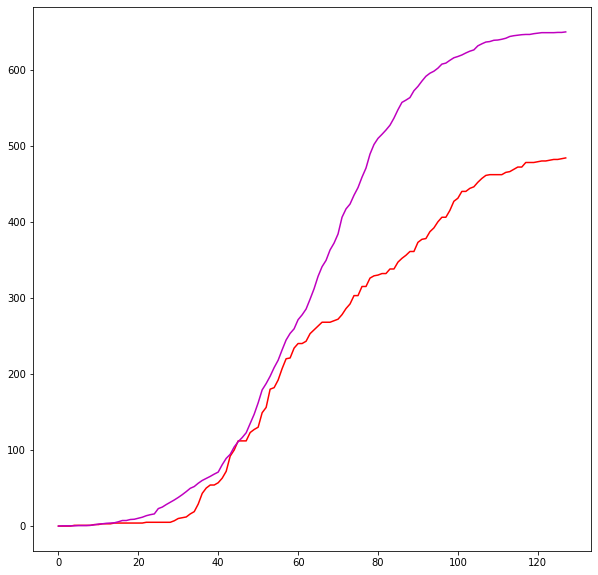

In [21]:
plt.rcParams["figure.figsize"] = (10,10)
actual_positive = [0,
0,
0,
0,
1,
1,
1,
1,
1,
2,
2,
3,
3,
3,
4,
4,
4,
4,
4,
4,
4,
4,
5,
5,
5,
5,
5,
5,
5,
7,
10,
11,
12,
16,
19,
29,
43,
50,
54,
54,
57,
63,
72,
92,
100,
112,
112,
112,
123,
127,
130,
149,
156,
180,
182,
192,
207,
220,
221,
234,
240,
240,
243,
253,
258,
263,
268,
268,
268,
270,
272,
278,
286,
292,
303,
303,
315,
315,
326,
329,
330,
332,
332,
338,
338,
347,
352,
356,
361,
361,
373,
377,
378,
387,
392,
400,
406,
406,
415,
427,
431,
440,
440,
444,
446,
452,
457,
461,
462,
462,
462,
462,
465,
466,
469,
472,
472,
478,
478,
478,
479,
480,
480,
481,
482,
482,
483,
484
]
plt.plot(actual_positive,'r', model1_positive,'m')
plt.show()


In [2]:
import h5py   
f = h5py.File('output_new_format.hdf5', 'r')
model5 = f['gen_14/trial_71/data/tests_performed_total/mean'][...]
model1_positive = f['gen_14/trial_63/data/positive_tests_total/mean'][...]
print(model5)
f.close()

[   0.          8.666667   15.333333   58.333332  104.        128.33333
  158.33333   179.33333   201.66667   230.33333   271.33334   319.
  350.        383.33334   410.66666   422.33334   450.33334   484.33334
  517.        550.        577.3333    597.3333    616.        647.
  695.3333    769.3333    792.6667    821.        844.6667    867.6667
  921.3333    955.6667    984.6667   1021.6667   1066.3334   1094.6666
 1119.6666   1155.6666   1189.3334   1248.6666   1285.6666   1320.6666
 1341.3334   1367.3334   1407.3334   1455.3334   1505.       1533.3334
 1577.       1604.3334   1625.6666   1668.3334   1692.3334   1734.3334
 1774.3334   1811.       1830.       1842.       1870.       1915.3334
 1951.6666   1986.6666   2021.6666   2042.       2057.6667   2078.6667
 2101.       2122.6667   2156.6667   2194.6667   2208.3333   2223.
 2254.       2285.6667   2304.3333   2324.3333   2351.       2371.6667
 2387.6667   2402.6667   2417.3333   2444.3333   2473.       2495.3333
 2508.       252

In [17]:
def find_empty(name, object):
    if 'mean' in name:
        print(name)
f = h5py.File('full_data.hdf5', 'r')
trial_78_data = f['gen_9/trial_78/data']
positive_cases = trial_78_data['positive_tests_total/all_runs'][...]
active_cases = trial_78_data['active_cases/all_runs'][...]
total_cases = trial_78_data['tests_performed_total/all_runs'][...]
print(type(positive_cases),type(active_cases),type(total_cases))
print(positive_cases)
print(active_cases)
f.close()

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  3  3
   5  5  5  6  6  6  7  7  9 11 12 13 15 17 18 20 21 22 22 25 28 32 33 34
  36 37 40 40 40 40 41 41 41 42 42 42 42 42 42 42 42 42 44 44 45 45 45 45
  45 45 45 45 45 45 46 46 46 46 46 46 46 46 46 47 47 47 47 47 47 47 47 47
  47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47
  47 47 47 47 47 47 47 47]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  7  9  9 11 12
  13 14 16 19 19 24 25 27 29 29 32 33 35 38 42 43 45 50 51 51 54 57 60 61
  64 64 65 65 67 67 67 67 67 67 68 68 68 68 68 68 68 68 68 68 68 68 68 68
  68 68 68 68 68 68 68 68 68 68 69 69 69 69 69 69 69 69 69 69 69 69 69 69
  69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
  69 69 69 69 69 69 69 69]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  3  4  5  5  6  7
   7  7  8  8 11 12 14 16 19 20 22 23 24 28 30 33 33 37 38 4

In [43]:
import json
f = h5py.File('full_data.hdf5', 'r')
total = 0
dictionary_list = []
# gets total number of data
for gen in f.values():
    for trial in gen.values():
        current_dict_l = list(json.loads(trial['parameters'][...].tolist()).keys())
        if dictionary_list != current_dict_l:
            print(trial.name)
        dictionary_list = current_dict_l

f.close()

/gen_1/trial_1


In [ ]:
hdf5_indexing = []
# indexed every 5. i.e index 6 would be stored in [1]. assumes all data in size
f = h5py.File('full_data.hdf5', 'r')
for gen in f.values():
    for trial in gen.values():
f.close()

In [81]:
import torch
import numpy as np
from torch.utils import data


class hdf5Dataset(data.Dataset):
    def __init__(self, hdf5_filename, multiple_runs):
        # multiple requests the number of multiple_runs stored together in all_runs
        self.multiple = multiple_runs
        self.index_hdf5 = []  # indexs stored in multiples of $multiple_runs i.e index[6] is the 6//multiple_runs folder
        self.filename = hdf5_filename
        self.populate_index()
        
        
    
    def populate_index(self):
        with h5py.File(self.filename, 'r') as f:
            for gen in f.values():
                for trial in gen.values():
                    self.index_hdf5.append(trial.name)
                    
    # remove unnessarry items from the parameter dictionarys
    def trim_dictionary(self,dictionary):
        bad_params = ['test','verbose','attendance_bins','scenario_name','parameter_checking',
                      'run_days', 'daily_outside_cases','removed_cohorts']
        for param in bad_params:
            dictionary.pop(param, 'None')
        
        return dictionary
        
    def get_flattened_data(self, f_trial, index):
        # iterate through all data groups
        data = []
        for group in f_trial['data'].values():
            print(group.name)
            data.append(group['all_runs'][...][index])
        
        # retruns np array and flattens
        return np.array(data)
        
        
        
    def __len__(self):
        # total size of database is number of trials * number of multiples in that trial
        return self.multiple * len(self.index_hdf5)
    
    def __getitem__(self, idx):
        '''
        find where specific index is by dividing index by number of sets 
        per trial ie index 0:(multiple-1) are all in index 1
        '''
        hdf5_path = self.index_hdf5[idx//self.multiple]
        
        # should add cocurrent read option
        with h5py.File(self.filename, 'r') as f:
            trial = f[hdf5_path]
            params = json.loads(trial['parameters'][...].tolist())
            cleaned_dict = self.trim_dictionary(params)
            data = self.get_flattened_data(trial, idx % self.multiple)
            
        return cleaned_dict, data
        
        
        
dataset = hdf5Dataset('full_data.hdf5', 5)

print(len(dataset))

print(dataset[1])

    

13040
/gen_1/trial_1/data/active_cases
/gen_1/trial_1/data/positive_tests_total
/gen_1/trial_1/data/tests_performed_total
({'quarantining': True, 'contact_tracing': False, 'initial_infected_fraction': 0.008619708241278272, 'initial_removed_fraction': 0.02175779323294851, 'incubation_period': 2.6706757568659585, 'serial_interval': 4.7134033814885825, 'symptomatic_fraction': 0.03593321725780918, 'recovery_days': 20, 'quarantine_days': 11, 'days_indetectable': 3, 'R0': 4.555787618005199, 'contact_rate': 14, 'npi_factor': 0.5224676567295896, 'contact_tracing_testing_rate': 0.10092351632396346, 'contact_tracing_quarantine_rate': 1.70230952975757, 'contact_tracing_days': 2, 'daily_testing_fraction': 0.0002910794077599299, 'daily_testing_false_positive': 0.0008604128566049769, 'daily_testing_false_negative': 0.05207555804497765, 'class_size_limit': 91, 'contact_upscale_factor': 0.8310176729187565, 'friendship_contacts': 3.023630779917669, 'academic_contacts': 4.385799484929049, 'broad_social_

In [79]:
print(dataset[6])

/gen_1/trial_10/data/active_cases
/gen_1/trial_10/data/positive_tests_total
/gen_1/trial_10/data/tests_performed_total
({'quarantining': False, 'contact_tracing': True, 'initial_infected_fraction': 0.007561852427764638, 'initial_removed_fraction': 0.05861303678585479, 'removed_cohorts': [], 'incubation_period': 2.793858425796114, 'serial_interval': 5.412440026096904, 'symptomatic_fraction': 0.2683669838881672, 'recovery_days': 3, 'quarantine_days': 20, 'days_indetectable': 2, 'R0': 2.2589265472939295, 'contact_rate': 10, 'npi_factor': 0.26802944119721356, 'daily_outside_cases': [1, 0, 0, 0], 'contact_tracing_testing_rate': 1.6336165830675013, 'contact_tracing_quarantine_rate': 1.0368189734067066, 'contact_tracing_days': 3, 'daily_testing_fraction': 0.0006810145865632636, 'daily_testing_false_positive': 0.0005657157577957508, 'daily_testing_false_negative': 0.023960933852030145, 'class_size_limit': 171, 'contact_upscale_factor': 0.966287190341376, 'friendship_contacts': 4.91263158834805